## 导入包

In [2]:
import numpy as np
import pandas as pd
import math
import collections

## 导入数据

In [3]:
def import_data():
    data = pd.read_csv('..\\source\\watermalon.txt')
    data.head(10)
    data=np.array(data).tolist()
    # 特征值列表
    labels = ['色泽', '根蒂', '敲击', '纹理', '脐部', '触感']

    # 特征对应的所有可能的情况
    labels_full = {}

    for i in range(len(labels)):
        labelList = [example[i] for example in data]
        uniqueLabel = set(labelList)
        labels_full[labels[i]] = uniqueLabel
    return data,labels,labels_full

In [4]:
data,labels,labels_full=import_data()

## 计算初始的信息熵

In [5]:
def calcShannonEnt(dataSet):
    """
    计算给定数据集的信息熵(香农熵)
    :param dataSet:
    :return:
    """
    # 计算出数据集的总数
    numEntries = len(dataSet)

    # 用来统计标签
    labelCounts = collections.defaultdict(int)

    # 循环整个数据集，得到数据的分类标签
    for featVec in dataSet:
        # 得到当前的标签
        currentLabel = featVec[-1]

        # # 如果当前的标签不再标签集中，就添加进去（书中的写法）
        # if currentLabel not in labelCounts.keys():
        #     labelCounts[currentLabel] = 0
        #
        # # 标签集中的对应标签数目加一
        # labelCounts[currentLabel] += 1

        # 也可以写成如下
        labelCounts[currentLabel] += 1

    # 默认的信息熵
    shannonEnt = 0.0

    for key in labelCounts:
        # 计算出当前分类标签占总标签的比例数
        prob = float(labelCounts[key]) / numEntries

        # 以2为底求对数
        shannonEnt -= prob * math.log2(prob)

    return shannonEnt



## 计算初始熵值以及根据每个变量分类所获得的信息增益

In [6]:
print(calcShannonEnt(data)) # 输出为：0.9975025463691153

0.9975025463691153


## 确定每个特征的数量

In [7]:
def splitDataSet(dataSet, axis, value):
    """
    按照给定的特征值，将数据集划分
    :param dataSet: 数据集
    :param axis: 给定特征值的坐标
    :param value: 给定特征值满足的条件，只有给定特征值等于这个value的时候才会返回
    :return:
    """
    # 创建一个新的列表，防止对原来的列表进行修改
    retDataSet = []

    # 遍历整个数据集
    for featVec in dataSet:
        # 如果给定特征值等于想要的特征值
        if featVec[axis] == value:
            # 将该特征值前面的内容保存起来
            reducedFeatVec = featVec[:axis]
            # 将该特征值后面的内容保存起来，所以将给定特征值给去掉了
            reducedFeatVec.extend(featVec[axis + 1:])
            # 添加到返回列表中
            retDataSet.append(reducedFeatVec)

    return retDataSet


## 计算信息增益来确定最好的数据集划分

In [8]:
def chooseBestFeatureToSplit(dataSet, labels):
    """
    选择最好的数据集划分特征，根据信息增益值来计算
    :param dataSet:
    :return:
    """
    # 得到数据的特征值总数
    numFeatures = len(dataSet[0]) - 1

    # 计算出基础信息熵
    baseEntropy = calcShannonEnt(dataSet)

    # 基础信息增益为0.0
    bestInfoGain = 0.0

    # 最好的特征值
    bestFeature = -1

    # 对每个特征值进行求信息熵
    for i in range(numFeatures):
        # 得到数据集中所有的当前特征值列表
        featList = [example[i] for example in dataSet]

        # 将当前特征唯一化，也就是说当前特征值中共有多少种
        uniqueVals = set(featList)

        # 新的熵，代表当前特征值的熵
        newEntropy = 0.0

        # 遍历现在有的特征的可能性
        for value in uniqueVals:
            # 在全部数据集的当前特征位置上，找到该特征值等于当前值的集合
            subDataSet = splitDataSet(dataSet=dataSet, axis=i, value=value)

            # 计算出权重
            prob = len(subDataSet) / float(len(dataSet))

            # 计算出当前特征值的熵
            newEntropy += prob * calcShannonEnt(subDataSet)

        # 计算出“信息增益”
        infoGain = baseEntropy - newEntropy

        #print('当前特征值为：' + labels[i] + '，对应的信息增益值为：' + str(infoGain)+"i等于"+str(i))

        #如果当前的信息增益比原来的大
        if infoGain > bestInfoGain:
            # 最好的信息增益
            bestInfoGain = infoGain
            # 新的最好的用来划分的特征值
            bestFeature = i

    #print('信息增益最大的特征为：' + labels[bestFeature])
    return bestFeature


In [9]:
bestFeature=chooseBestFeatureToSplit(data,labels)

## 判断各个样本集的各个属性是否一致

In [10]:
def judgeEqualLabels(dataSet):
    """
    判断数据集的各个属性集是否完全一致
    :param dataSet:
    :return:
    """
    # 计算出样本集中共有多少个属性，最后一个为类别
    feature_leng = len(dataSet[0]) - 1

    # 计算出共有多少个数据
    data_leng = len(dataSet)

    # 标记每个属性中第一个属性值是什么
    first_feature = ''

    # 各个属性集是否完全一致
    is_equal = True

    # 遍历全部属性
    for i in range(feature_leng):
        # 得到第一个样本的第i个属性
        first_feature = dataSet[0][i]

        # 与样本集中所有的数据进行对比，看看在该属性上是否都一致
        for _ in range(1, data_leng):
            # 如果发现不相等的，则直接返回False
            if first_feature != dataSet[_][i]:
                return False

    return is_equal



## 绘制决策树（字典）

In [11]:
def createTree(dataSet, labels):
    """
    创建决策树
    :param dataSet: 数据集
    :param labels: 特征标签
    :return:
    """
    # 拿到所有数据集的分类标签
    classList = [example[-1] for example in dataSet]

    # 统计第一个标签出现的次数，与总标签个数比较，如果相等则说明当前列表中全部都是一种标签，此时停止划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]

    # 计算第一行有多少个数据，如果只有一个的话说明所有的特征属性都遍历完了，剩下的一个就是类别标签，或者所有的样本在全部属性上都一致
    if len(dataSet[0]) == 1 or judgeEqualLabels(dataSet):
        # 返回剩下标签中出现次数较多的那个
        return majorityCnt(classList)

    # 选择最好的划分特征，得到该特征的下标
    bestFeat = chooseBestFeatureToSplit(dataSet=dataSet, labels=labels)
    print(bestFeat)
    # 得到最好特征的名称
    bestFeatLabel = labels[bestFeat]
    print(bestFeatLabel)
    # 使用一个字典来存储树结构，分叉处为划分的特征名称
    myTree = {bestFeatLabel: {}}

    # 将本次划分的特征值从列表中删除掉
    del(labels[bestFeat])

    # 得到当前特征标签的所有可能值
    featValues = [example[bestFeat] for example in dataSet]

    # 唯一化，去掉重复的特征值
    uniqueVals = set(featValues)

    # 遍历所有的特征值
    for value in uniqueVals:
        # 得到剩下的特征标签
        subLabels = labels[:]
        subTree = createTree(splitDataSet(dataSet=dataSet, axis=bestFeat, value=value), subLabels)
        # 递归调用，将数据集中该特征等于当前特征值的所有数据划分到当前节点下，递归调用时需要先将当前的特征去除掉
        myTree[bestFeatLabel][value] = subTree
    return myTree


In [12]:
mytree=createTree(data,labels)
print(mytree)

3
纹理
1
根蒂
0
色泽
2
触感
4
触感
{'纹理': {'清晰': {'根蒂': {'稍蜷': {'色泽': {'青绿': '是', '乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}}}, '硬挺': '否', '蜷缩': '是'}}, '稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}, '模糊': '否'}}


## 绘制可视化树

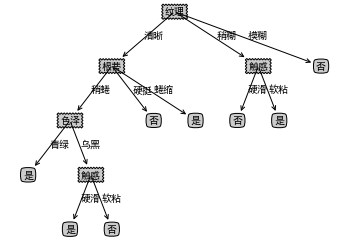

In [13]:


import matplotlib.pylab as plt
import matplotlib

# 能够显示中文
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.serif'] = ['SimHei']

# 分叉节点，也就是决策节点
decisionNode = dict(boxstyle="sawtooth", fc="0.8")

# 叶子节点
leafNode = dict(boxstyle="round4", fc="0.8")

# 箭头样式
arrow_args = dict(arrowstyle="<-")


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    """
    绘制一个节点
    :param nodeTxt: 描述该节点的文本信息
    :param centerPt: 文本的坐标
    :param parentPt: 点的坐标，这里也是指父节点的坐标
    :param nodeType: 节点类型,分为叶子节点和决策节点
    :return:
    """
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)


def getNumLeafs(myTree):
    """
    获取叶节点的数目
    :param myTree:
    :return:
    """
    # 统计叶子节点的总数
    numLeafs = 0

    # 得到当前第一个key，也就是根节点
    firstStr = list(myTree.keys())[0]

    # 得到第一个key对应的内容
    secondDict = myTree[firstStr]

    # 递归遍历叶子节点
    for key in secondDict.keys():
        # 如果key对应的是一个字典，就递归调用
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        # 不是的话，说明此时是一个叶子节点
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    """
    得到数的深度层数
    :param myTree:
    :return:
    """
    # 用来保存最大层数
    maxDepth = 0

    # 得到根节点
    firstStr = list(myTree.keys())[0]

    # 得到key对应的内容
    secondDic = myTree[firstStr]

    # 遍历所有子节点
    for key in secondDic.keys():
        # 如果该节点是字典，就递归调用
        if type(secondDic[key]).__name__ == 'dict':
            # 子节点的深度加1
            thisDepth = 1 + getTreeDepth(secondDic[key])

        # 说明此时是叶子节点
        else:
            thisDepth = 1

        # 替换最大层数
        if thisDepth > maxDepth:
            maxDepth = thisDepth

    return maxDepth


def plotMidText(cntrPt, parentPt, txtString):
    """
    计算出父节点和子节点的中间位置，填充信息
    :param cntrPt: 子节点坐标
    :param parentPt: 父节点坐标
    :param txtString: 填充的文本信息
    :return:
    """
    # 计算x轴的中间位置
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    # 计算y轴的中间位置
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    # 进行绘制
    createPlot.ax1.text(xMid, yMid, txtString)


def plotTree(myTree, parentPt, nodeTxt):
    """
    绘制出树的所有节点，递归绘制
    :param myTree: 树
    :param parentPt: 父节点的坐标
    :param nodeTxt: 节点的文本信息
    :return:
    """
    # 计算叶子节点数
    numLeafs = getNumLeafs(myTree=myTree)

    # 计算树的深度
    depth = getTreeDepth(myTree=myTree)

    # 得到根节点的信息内容
    firstStr = list(myTree.keys())[0]

    # 计算出当前根节点在所有子节点的中间坐标,也就是当前x轴的偏移量加上计算出来的根节点的中心位置作为x轴（比如说第一次：初始的x偏移量为：-1/2W,计算出来的根节点中心位置为：(1+W)/2W，相加得到：1/2），当前y轴偏移量作为y轴
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)

    # 绘制该节点与父节点的联系
    plotMidText(cntrPt, parentPt, nodeTxt)

    # 绘制该节点
    plotNode(firstStr, cntrPt, parentPt, decisionNode)

    # 得到当前根节点对应的子树
    secondDict = myTree[firstStr]

    # 计算出新的y轴偏移量，向下移动1/D，也就是下一层的绘制y轴
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD

    # 循环遍历所有的key
    for key in secondDict.keys():
        # 如果当前的key是字典的话，代表还有子树，则递归遍历
        if isinstance(secondDict[key], dict):
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            # 计算新的x轴偏移量，也就是下个叶子绘制的x轴坐标向右移动了1/W
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            # 打开注释可以观察叶子节点的坐标变化
            # print((plotTree.xOff, plotTree.yOff), secondDict[key])
            # 绘制叶子节点
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            # 绘制叶子节点和父节点的中间连线内容
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))

    # 返回递归之前，需要将y轴的偏移量增加，向上移动1/D，也就是返回去绘制上一层的y轴
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD


def createPlot(inTree):
    """
    需要绘制的决策树
    :param inTree: 决策树字典
    :return:
    """
    # 创建一个图像
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    # 计算出决策树的总宽度
    plotTree.totalW = float(getNumLeafs(inTree))
    # 计算出决策树的总深度
    plotTree.totalD = float(getTreeDepth(inTree))
    # 初始的x轴偏移量，也就是-1/2W，每次向右移动1/W，也就是第一个叶子节点绘制的x坐标为：1/2W，第二个：3/2W，第三个：5/2W，最后一个：(W-1)/2W
    plotTree.xOff = -0.5/plotTree.totalW
    # 初始的y轴偏移量，每次向下或者向上移动1/D
    plotTree.yOff = 1.0
    # 调用函数进行绘制节点图像
    plotTree(inTree, (0.5, 1.0), '')
    # 绘制
    plt.show()


if __name__ == '__main__':
    createPlot(mytree)


## 补全决策树

In [14]:
def makeTreeFull(myTree, labels_full, default):
    """
    将树中的不存在的特征标签进行补全，补全为父节点中出现最多的类别
    :param myTree: 生成的树
    :param labels_full: 特征的全部标签
    :param parentClass: 父节点中所含最多的类别
    :param default: 如果缺失标签中父节点无法判断类别则使用该值
    :return:
    """
    # 这里所说的父节点就是当前根节点，把当前根节点下不存在的特征标签作为子节点

    # 拿到当前的根节点
    root_key = list(myTree.keys())[0]

    # 拿到根节点下的所有分类，可能是子节点（好瓜or坏瓜）也可能不是子节点（再次划分的属性值）
    sub_tree = myTree[root_key]

    # 如果是叶子节点就结束
    if isinstance(sub_tree, str):
        return

    # 找到使用当前节点分类下最多的种类，该分类结果作为新特征标签的分类，如：色泽下面没有浅白则用色泽中有的青绿分类作为浅白的分类
    root_class = []
    # 把已经分好类的结果记录下来
    for sub_key in sub_tree.keys():
        if isinstance(sub_tree[sub_key], str):
            root_class.append(sub_tree[sub_key])

    # 找到本层出现最多的类别，可能会出现相同的情况取其一
    if len(root_class):
        most_class = collections.Counter(root_class).most_common(1)[0][0]
    else:
        most_class = None# 当前节点下没有已经分类好的属性
    # print(most_class)

    # 循环遍历全部特征标签，将不存在标签添加进去
    for label in labels_full[root_key]:
        if label not in sub_tree.keys():
            if most_class is not None:
                sub_tree[label] = most_class
            else:
                sub_tree[label] = default

    # 递归处理
    for sub_key in sub_tree.keys():
        if isinstance(sub_tree[sub_key], dict):
            makeTreeFull(myTree=sub_tree[sub_key], labels_full=labels_full, default=default)



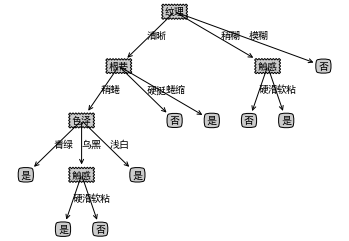

In [15]:
makeTreeFull(mytree,labels_full,default='未知')
createPlot(mytree)

## 使用sklearn包生成决策树

In [16]:
# 导入包
import pandas as pd
from sklearn import tree
import graphviz

In [17]:
df = pd.read_csv('..\\source\\watermalon.txt')
df.head(10)

,色泽,根蒂,敲声,纹理,脐部,触感,好瓜
0,青绿,蜷缩,浊响,清晰,凹陷,硬滑,是
1,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,是
2,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,是
3,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,是
4,浅白,蜷缩,浊响,清晰,凹陷,硬滑,是
5,青绿,稍蜷,浊响,清晰,稍凹,软粘,是
6,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,是
7,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,是
8,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,否
9,青绿,硬挺,清脆,清晰,平坦,软粘,否


In [18]:
df['色泽']=df['色泽'].map({'浅白':1,'青绿':2,'乌黑':3})
df['根蒂']=df['根蒂'].map({'稍蜷':1,'蜷缩':2,'硬挺':3})
df['敲声']=df['敲声'].map({'清脆':1,'浊响':2,'沉闷':3})
df['纹理']=df['纹理'].map({'清晰':1,'稍糊':2,'模糊':3})
df['脐部']=df['脐部'].map({'平坦':1,'稍凹':2,'凹陷':3})
df['触感'] = np.where(df['触感']=="硬滑",1,2)
df['好瓜'] = np.where(df['好瓜']=="是",1,0)
x_train=df[['色泽','根蒂','敲声','纹理','脐部','触感']]
y_train=df['好瓜']
print(df)
id3=tree.DecisionTreeClassifier(criterion='entropy')
id3=id3.fit(x_train,y_train)
print(id3)

    色泽  根蒂  敲声  纹理  脐部  触感  好瓜
0    2   2   2   1   3   1   1
1    3   2   3   1   3   1   1
2    3   2   2   1   3   1   1
3    2   2   3   1   3   1   1
4    1   2   2   1   3   1   1
5    2   1   2   1   2   2   1
6    3   1   2   2   2   2   1
7    3   1   2   1   2   1   1
8    3   1   3   2   2   1   0
9    2   3   1   1   1   2   0
10   1   3   1   3   1   1   0
11   1   2   2   3   1   2   0
12   2   1   2   2   3   1   0
13   1   1   3   2   3   1   0
14   3   1   2   1   2   2   0
15   1   2   2   3   1   1   0
16   2   2   3   2   2   1   0
DecisionTreeClassifier(criterion='entropy')


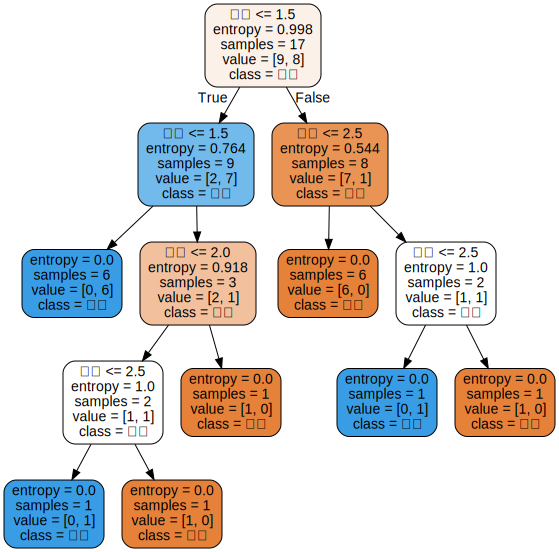

In [19]:
labels = ['色泽', '根蒂', '敲击', '纹理', '脐部', '触感']
dot_data = tree.export_graphviz(id3
,feature_names=labels
,class_names=["好瓜","坏瓜"]
,filled=True
,rounded=True
)
graph = graphviz.Source(dot_data)
graph


## 实现CART算法

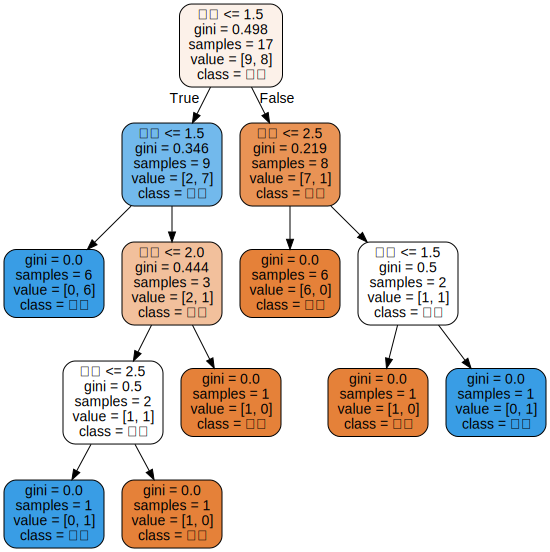

In [20]:
# 构建模型并训练
gini=tree.DecisionTreeClassifier()
gini=gini.fit(x_train,y_train)
#实现决策树的可视化
gini_data = tree.export_graphviz(gini
,feature_names=labels
,class_names=["好瓜","坏瓜"]
,filled=True
,rounded=True
)
gini_graph = graphviz.Source(gini_data)
gini_graph

In [21]:
## 实现C4.5算法
def chooseBestFeatureToSplit_4(dataSet, labels):
    """
    选择最好的数据集划分特征，根据信息增益值来计算
    :param dataSet:
    :return:
    """
    # 得到数据的特征值总数
    numFeatures = len(dataSet[0]) - 1

    # 计算出基础信息熵
    baseEntropy = calcShannonEnt(dataSet)

    # 基础信息增益为0.0
    bestInfoGain = 0.0

    # 最好的特征值
    bestFeature = -1

    # 对每个特征值进行求信息熵
    for i in range(numFeatures):
        # 得到数据集中所有的当前特征值列表
        featList = [example[i] for example in dataSet]

        # 将当前特征唯一化，也就是说当前特征值中共有多少种
        uniqueVals = set(featList)

        # 新的熵，代表当前特征值的熵
        newEntropy = 0.0

        # 遍历现在有的特征的可能性
        for value in uniqueVals:
            # 在全部数据集的当前特征位置上，找到该特征值等于当前值的集合
            subDataSet = splitDataSet(dataSet=dataSet, axis=i, value=value)

            # 计算出权重
            prob = len(subDataSet) / float(len(dataSet))

            # 计算出当前特征值的熵
            newEntropy += prob * calcShannonEnt(subDataSet)

        # 计算出“信息增益”
        infoGain = baseEntropy - newEntropy
        infoGain = infoGain/newEntropy

        #print('当前特征值为：' + labels[i] + '，对应的信息增益值为：' + str(infoGain)+"i等于"+str(i))

        #如果当前的信息增益比原来的大
        if infoGain > bestInfoGain:
            # 最好的信息增益
            bestInfoGain = infoGain
            # 新的最好的用来划分的特征值
            bestFeature = i

    #print('信息增益最大的特征为：' + labels[bestFeature])
    return bestFeature

In [22]:
def createTree_4(dataSet, labels):
    """
    创建决策树
    :param dataSet: 数据集
    :param labels: 特征标签
    :return:
    """
    # 拿到所有数据集的分类标签
    classList = [example[-1] for example in dataSet]

    # 统计第一个标签出现的次数，与总标签个数比较，如果相等则说明当前列表中全部都是一种标签，此时停止划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]

    # 计算第一行有多少个数据，如果只有一个的话说明所有的特征属性都遍历完了，剩下的一个就是类别标签，或者所有的样本在全部属性上都一致
    if len(dataSet[0]) == 1 or judgeEqualLabels(dataSet):
        # 返回剩下标签中出现次数较多的那个
        return majorityCnt(classList)

    # 选择最好的划分特征，得到该特征的下标
    bestFeat = chooseBestFeatureToSplit_4(dataSet=dataSet, labels=labels)
    print(bestFeat)
    # 得到最好特征的名称
    bestFeatLabel = labels[bestFeat]
    print(bestFeatLabel)
    # 使用一个字典来存储树结构，分叉处为划分的特征名称
    myTree = {bestFeatLabel: {}}

    # 将本次划分的特征值从列表中删除掉
    del(labels[bestFeat])

    # 得到当前特征标签的所有可能值
    featValues = [example[bestFeat] for example in dataSet]

    # 唯一化，去掉重复的特征值
    uniqueVals = set(featValues)

    # 遍历所有的特征值
    for value in uniqueVals:
        # 得到剩下的特征标签
        subLabels = labels[:]
        subTree = createTree(splitDataSet(dataSet=dataSet, axis=bestFeat, value=value), subLabels)
        # 递归调用，将数据集中该特征等于当前特征值的所有数据划分到当前节点下，递归调用时需要先将当前的特征去除掉
        myTree[bestFeatLabel][value] = subTree
    return myTree


In [23]:
mytree_4=createTree_4(data,labels)
print(mytree_4)

3
纹理
1
根蒂
0
色泽
2
触感
4
触感
{'纹理': {'清晰': {'根蒂': {'稍蜷': {'色泽': {'青绿': '是', '乌黑': {'触感': {'硬滑': '是', '软粘': '否'}}}}, '硬挺': '否', '蜷缩': '是'}}, '稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}, '模糊': '否'}}


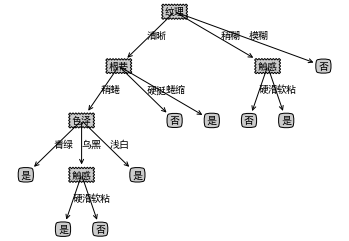

In [24]:
makeTreeFull(mytree_4,labels_full,default='未知')
createPlot(mytree_4)